# Data Fusion Contest 2024 - Problem 2 «Churn»
https://ods.ai/competitions/data-fusion2024-churn

## Data

1. Tabular client data:
Several datasets and artifacts are available to participants:   
- Basic information about all **96,000** clients in tabular .csv format: ***clients.csv*** (2.5 MB).
- Training data on the **target variable** and **last transaction time** for **64,000** clients: ***train.csv*** (745 KB).
- Reporting information where clients are grouped by time: ***report_dates.csv*** (288 KB).

2. Client transaction data:  
- Client transactions for all **96,000** clients (~13M) in tabular .csv format: ***transactions.csv.zip*** (197 MB).

## Fields

***clients.csv*** - basic information about clients:
- **user_id** - bank client ID,
- **report** - number of one of 12 reports this client was included in,
- **employee_count_nm** - information about client's employer: number of employees in the company,
- **bankemplstatus** - information about whether the client is an employee of the bank,
- **customer_age** - obfuscated age of the client (one of 4 groups 0..3).

***train.csv*** - training data with target variable about clients:
- **user_id** - bank client ID,
- **target** - client's churn label (target class of churn event is 1),
- **time** - in how many days the last transaction of the client will occur (can be used as survival time in Time-to-Event analysis).

***report_dates.csv*** - information about report dates:
- **report** - report sequence number,
- **report_dt** - report date.

***transactions.csv.zip*** - archive with transactions of bank clients:
- **user_id** - bank client ID,
- **mcc_code** - transaction mcc code,
- **currency_rk** - currency of transaction (1 - RUB, 2 - EUR, 3 - USD, 0 - any other currency),
- **transaction_dttm** - date and time of transaction execution,
- **transaction_amt** - amount in transaction currency.


In [1]:
import pandas as pd
import numpy as np

from datetime import timedelta
from tqdm import tqdm
from scipy.stats import skew

from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

from pathlib import Path
from params_manager import seed_everything, get_column_names

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

sns.set()
tqdm.pandas() 
pd.options.display.max_columns = None
pd.options.display.max_rows = 200

Enable ***tqdm*** for pandas, so we can run `progress_apply()` instead of just `apply()`

In [3]:
from params_manager import DATASETS_PATH, INTERNAL_PATH

seed = 42

Path(INTERNAL_PATH).mkdir(parents=True, exist_ok=True)

## All custom functions

In [4]:
def plot_distributions(data, data_name='train', classes=('target',),
                       normalize=False, ascending=False, sort_index=False, cols=3):
    rows, cols = (int(len(classes) / cols) + len(classes) % cols,
                  len(classes) if len(classes) < cols else cols)
    plt.figure(figsize=(16, 5*rows))
    plt.suptitle(f'{", ".join(classes)} distributions in {data_name}')

    for i, col in enumerate(classes):
        plt.subplot(rows, cols, i + 1)
        counts = data[col].value_counts(normalize=normalize, ascending=ascending)
        if sort_index:
            counts = counts.sort_index()
        counts, ylabel, fmt = (counts * 100, '%', '%.2f') if normalize else (counts, 'count', '%g')
        ax = counts.plot.bar(rot=45)
        ax.set_ylabel(ylabel)
        ax.bar_label(ax.containers[0], fmt=fmt)


def plot_churn_over_time(data, title, log=False):
    plt.bar(range(1, 92), data, width=1.0, linewidth=0.0, log=log)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Log (Count)' if log else 'Count')


def get_types(series):
    return [(col, type(val)) for col, val in series.items()]


def create_money_dict(df:pd.DataFrame):
    money_dict = {}
    for y, m, c in df.reset_index()[['year', 'month', 'curs']].to_dict('split')['data']:
        if y not in money_dict:
            money_dict[y] = {}
        money_dict[y][m] = c
    return money_dict


def amt_normalize(x):
    normal_amt = x.transaction_amt
    # Converting currency to RUB
    if x.currency_rk == 2:
        normal_amt = normal_amt * EUR_dict[x.year][x.month]
    elif x.currency_rk == 3:
        normal_amt = normal_amt * USD_dict[x.year][x.month]
    elif x.currency_rk == 0:
        normal_amt = normal_amt * CNY_dict[x.year][x.month]
    # Factoring in inflation
    normal_amt = normal_amt * INFL_dict[x.year][x.month]
    return normal_amt


# Since SciPy 1.11.0 non-numeric array support in scipy.stats.mode is removed
# https://github.com/scipy/scipy/issues/15551
# Below is a substitute function
def mode(arr):
    # Empty arr will throw an error!
    # if arr.size == 0:
        # return np.nan
    
    vals, counts = np.unique(arr, return_counts=True)
    index = np.argmax(counts)
    return vals[index], counts.max()


def non_active_period(sub_df):
    sub_df = sub_df.sort_values(by=['user_id', 'transaction_dttm'], ascending=True)
    sub_df['pre_transaction_dttm'] = sub_df['transaction_dttm'].shift(1)
    sub_df['non_active_period'] = (sub_df['transaction_dttm'] - sub_df['pre_transaction_dttm']).dt.days
    unique_active_days = len(sub_df['transaction_dttm'].dt.date.unique())
    active_period = len(sub_df[sub_df['non_active_period'] <= 1]) # multiple transactions in a row with less than a day interval between them (active transaction flow)
    all_period = (sub_df['transaction_dttm'].max() - sub_df['transaction_dttm'].min()).days + 1
    
    count_account_hit = len(sub_df[sub_df['transaction_amt'] > 0])
    count_account_charge = len(sub_df[sub_df['transaction_amt'] < 0])

    first_account_hit = sub_df[sub_df['transaction_amt'] > 0]['transaction_dttm'].min()
    first_account_charge = sub_df[sub_df['transaction_amt'] < 0]['transaction_dttm'].min()
    
    last_account_hit = sub_df[sub_df['transaction_amt'] > 0]['transaction_dttm'].max()
    last_account_charge = sub_df[sub_df['transaction_amt'] < 0]['transaction_dttm'].max()

    return (last_account_hit, last_account_charge, first_account_hit,
            first_account_charge, active_period, unique_active_days,
            all_period, sub_df['non_active_period'].median(), sub_df['non_active_period'].max(),
            active_period/len(sub_df), active_period/all_period,
            unique_active_days/len(sub_df), unique_active_days/all_period,
            count_account_hit, count_account_charge)


def speed_charge(sub_df, eps = 1e-5):
    sub_plus_df = sub_df[sub_df['transaction_amt'] > 0]
    sub_minus_df = sub_df[sub_df['transaction_amt'] < 0]
    last_user_date = sub_df['transaction_dttm'].max()
    
    cur_period_sum_plus = sub_plus_df[sub_plus_df['transaction_dttm'].between(last_user_date - timedelta(days=30), last_user_date)]['transaction_amt'].sum()
    pre_period_sum_plus = sub_plus_df[sub_plus_df['transaction_dttm'].between(last_user_date - timedelta(days=60), last_user_date - timedelta(days=30))]['transaction_amt'].sum()
    pre_pre_period_sum_plus = sub_plus_df[sub_plus_df['transaction_dttm'].between(last_user_date - timedelta(days=90), last_user_date - timedelta(days=60))]['transaction_amt'].sum()

    cur_period_sum_minus = abs(sub_minus_df[sub_minus_df['transaction_dttm'].between(last_user_date - timedelta(days=30), last_user_date)]['transaction_amt'].sum())
    pre_period_sum_minus = abs(sub_minus_df[sub_minus_df['transaction_dttm'].between(last_user_date - timedelta(days=60), last_user_date - timedelta(days=30))]['transaction_amt'].sum())
    pre_pre_period_sum_minus = abs(sub_minus_df[sub_minus_df['transaction_dttm'].between(last_user_date - timedelta(days=90), last_user_date - timedelta(days=60))]['transaction_amt'].sum())
    
    plus_speed_cur = cur_period_sum_plus / (pre_period_sum_plus + eps)
    plus_speed_pre = pre_period_sum_plus / (pre_pre_period_sum_plus + eps)
    plus_speed_cur_prepre = cur_period_sum_plus / (pre_pre_period_sum_plus + eps)
    
    minus_speed_cur = cur_period_sum_minus / (pre_period_sum_minus + eps)
    minus_speed_pre = pre_period_sum_minus / (pre_pre_period_sum_minus + eps)
    minus_speed_cur_prepre = cur_period_sum_minus / (pre_pre_period_sum_minus + eps)
    
    return (cur_period_sum_plus, pre_period_sum_plus, pre_pre_period_sum_plus, 
            cur_period_sum_minus, pre_period_sum_minus, pre_pre_period_sum_minus, 
            plus_speed_cur, plus_speed_pre, plus_speed_cur_prepre,
            minus_speed_cur, minus_speed_pre, minus_speed_cur_prepre) 


def plot_feature_importance(importance, names, model_name="", top_n=-1, skip_columns=None):
    """Feature importance output function
        :importance - array of feature importance obtained from the model
        :names - array of feature names
        :model_name - model name
        :top_n - number of output features
        :skip_columns: features to skip
        
        return - fi_df - feature importance dataframe
    """
    if skip_columns is None:
        skip_columns = []
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df = fi_df[~fi_df['feature_names'].isin(skip_columns)]
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    plt.figure(figsize=(10,8))
    sns.barplot(x=fi_df['feature_importance'][:top_n], y=fi_df['feature_names'][:top_n])
    if top_n != -1:
        plt.title(f"{model_name} FEATURE IMPORTANCE (Top: {top_n})")
    else:
        plt.title(f"{model_name} FEATURE IMPORTANCE")
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    return fi_df

def median_absolute_percentage_error(y_true, y_pred):
    mdape = np.median((np.abs(np.subtract(y_true, y_pred) / y_true))) * 100
    return mdape

def maximum_absolute_error(y_true, y_pred, quantile=1):
    paired_error = np.abs(np.subtract(y_true, y_pred))
    max_error = np.quantile(paired_error, quantile)
    return max_error


# Data upload

In [5]:
clients_df = pd.read_csv(DATASETS_PATH / 'clients.csv')
src_train_df = pd.read_csv(DATASETS_PATH / 'train.csv')
report_dates_df = pd.read_csv(DATASETS_PATH / 'report_dates.csv')
transactions_df = pd.read_csv(DATASETS_PATH / 'transactions.csv')

clients_df.shape, src_train_df.shape, report_dates_df.shape, transactions_df.shape

((96000, 5), (64000, 3), (12, 2), (13075023, 5))

# Exploratory Data Analysis

## Target variable

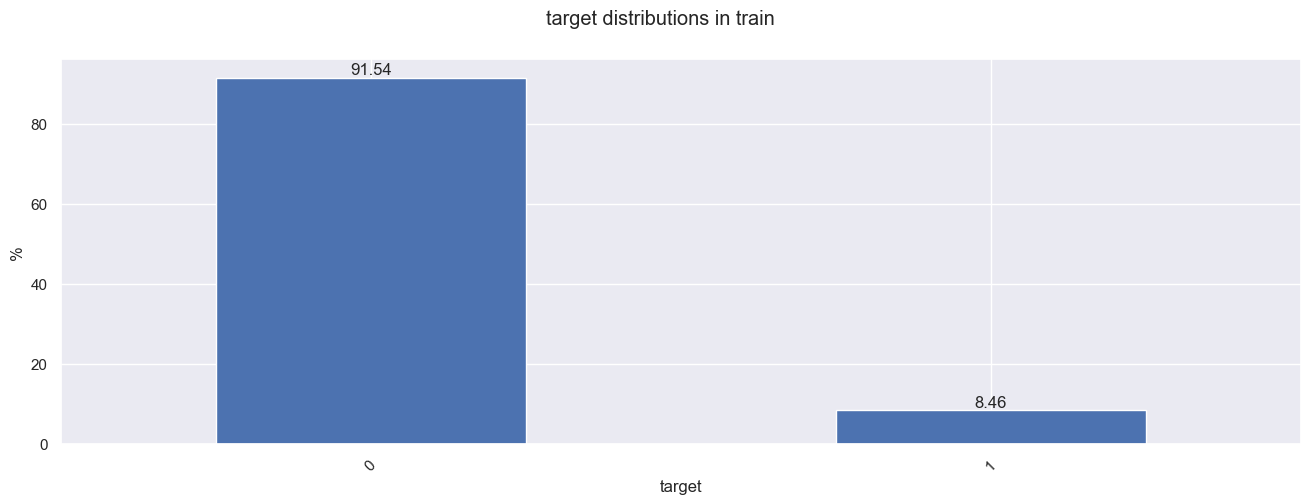

In [6]:
plot_distributions(src_train_df, classes=('target',), normalize=True)

Class imbalance

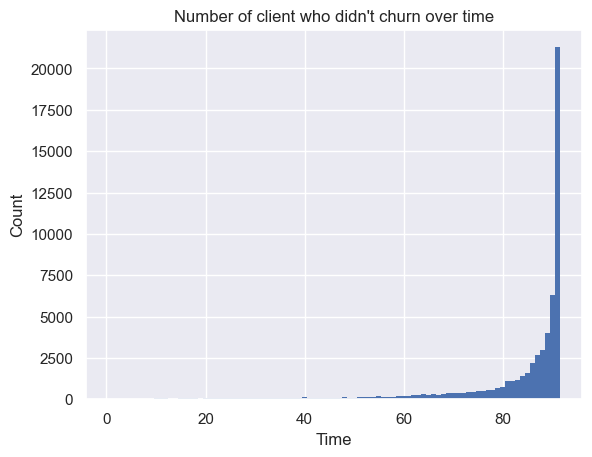

In [7]:
plot_churn_over_time(
    src_train_df[src_train_df['target'] == 0]['time'].value_counts(sort=False).sort_index(),
    'Number of client who didn\'t churn over time'
)

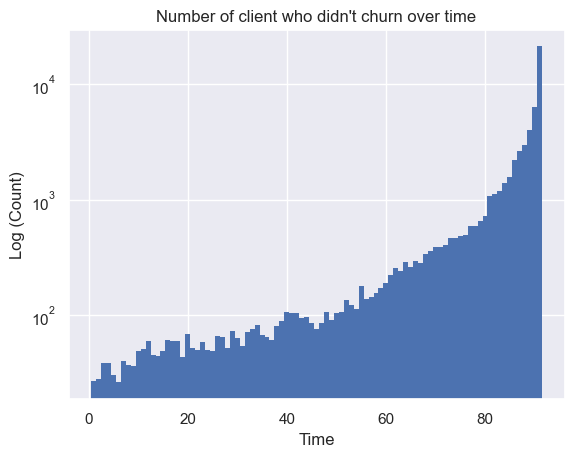

In [8]:
plot_churn_over_time(
    src_train_df[src_train_df['target'] == 0]['time'].value_counts(sort=False).sort_index(),
    'Number of client who didn\'t churn over time',
    log=True
)

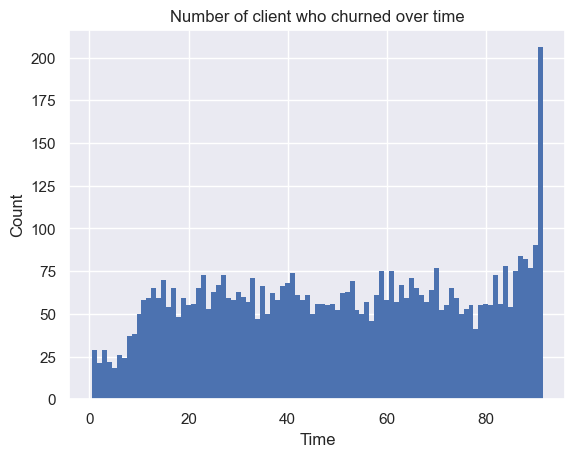

In [9]:
plot_churn_over_time(
    src_train_df[src_train_df['target'] == 1]['time'].value_counts(sort=False).sort_index(),
    'Number of client who churned over time'
)

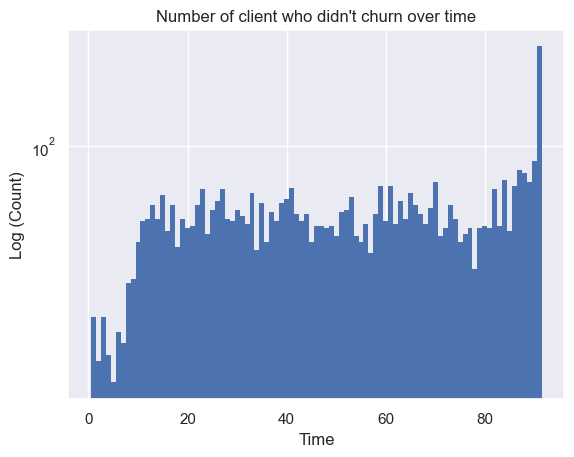

In [10]:
plot_churn_over_time(
    src_train_df[src_train_df['target'] == 1]['time'].value_counts(sort=False).sort_index(),
    'Number of client who didn\'t churn over time',
    log=True
)

Figures depict the class disparity and churn rate over a 90-day period. The number of customers who churned remains fairly consistent, except for a few fluctuations at the beginning and end of the period. In contrast, the number of customers who did not churn exponentially grows over time, leading to a class imbalance.

In [11]:
train_clients_df = src_train_df.merge(clients_df, on='user_id', how='left')
train_clients_df.shape

(64000, 7)

## Reports

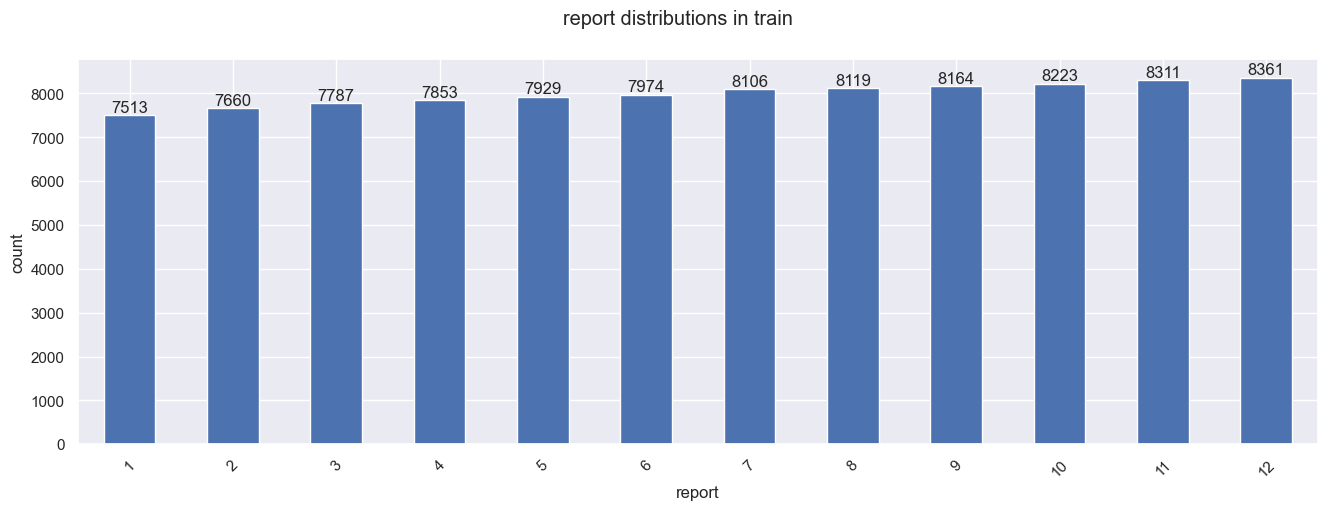

In [12]:
plot_distributions(clients_df, classes=('report',), sort_index=True)

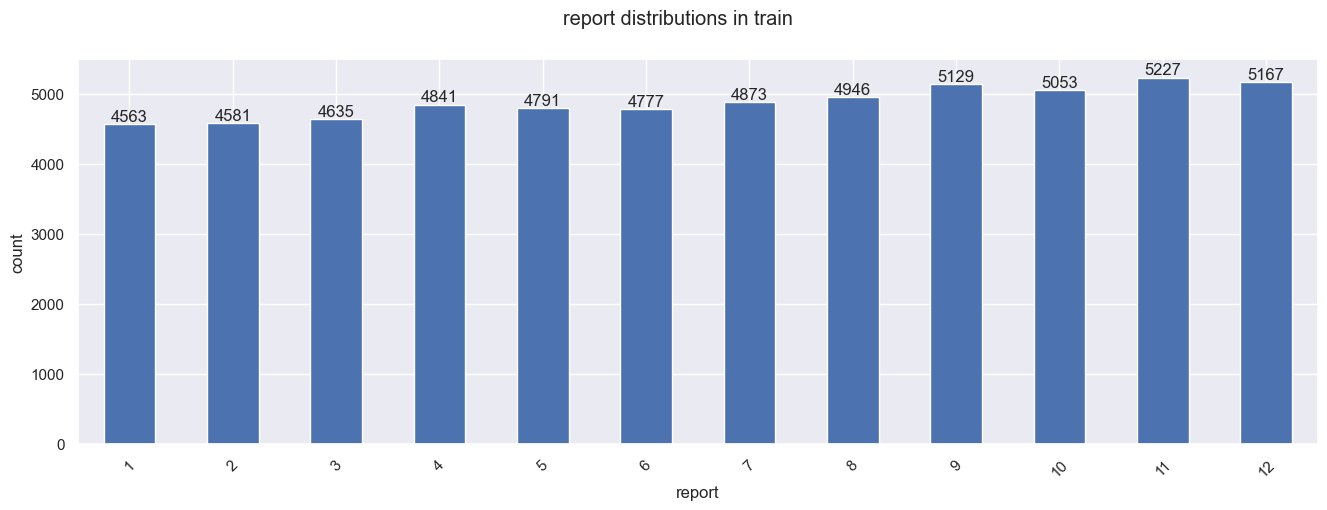

In [13]:
plot_distributions(train_clients_df[train_clients_df['target'] == 0], classes=('report',), sort_index=True)

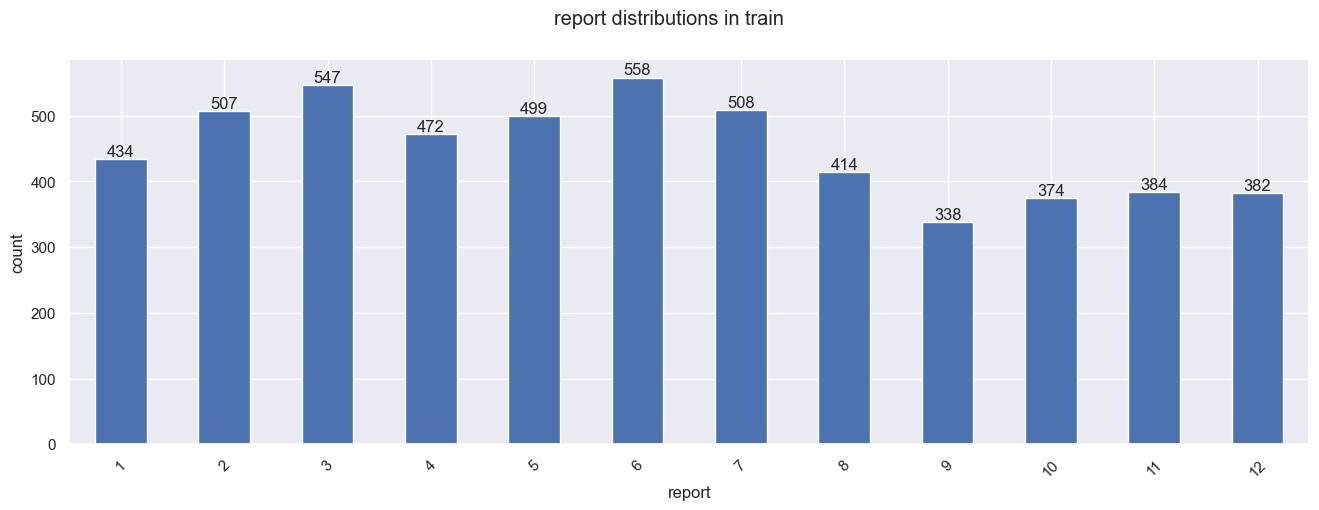

In [14]:
plot_distributions(train_clients_df[train_clients_df['target'] == 1], classes=('report',), sort_index=True)

## Transactions

In [15]:
transactions_reports_df = transactions_df.merge(train_clients_df, on='user_id', how='left')
transactions_reports_df.shape

(13075023, 11)

In [16]:
transactions_r8 = transactions_reports_df[transactions_reports_df['report'] == 8]

In [17]:
seed_everything(0)
random_u40_in_r8 = np.random.choice(train_clients_df[train_clients_df['report'] == 8]['user_id'].unique(), 40, replace=False)
random_u40_in_r8_map = {v: i for i, v in enumerate(random_u40_in_r8)}
random_u40_in_r8.shape

(40,)

In [18]:
transactions_r8_u40 = transactions_r8[transactions_r8['user_id'].isin(random_u40_in_r8)]
transactions_r8_u40.shape

(3940, 11)

In [19]:
transactions_r8_u40['transaction_dttm'] = pd.to_datetime(transactions_r8_u40['transaction_dttm'])
transactions_r8_u40['index'] = transactions_r8_u40['user_id'].replace(random_u40_in_r8_map)
np.sort(transactions_r8_u40['index'].unique())

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39], dtype=int64)

Text(0, 0.5, 'Users')

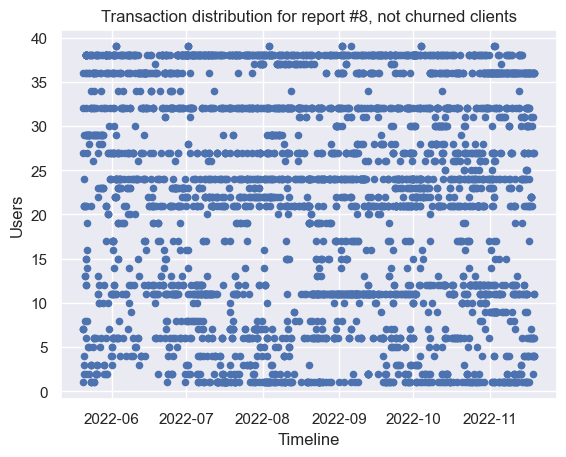

In [20]:
transactions_r8_u40[transactions_r8_u40['target'] == 0].plot.scatter(x='transaction_dttm', y='index')
plt.title('Transaction distribution for report #8, not churned clients')
plt.xlabel('Timeline')
plt.ylabel('Users')

Text(0, 0.5, 'Users')

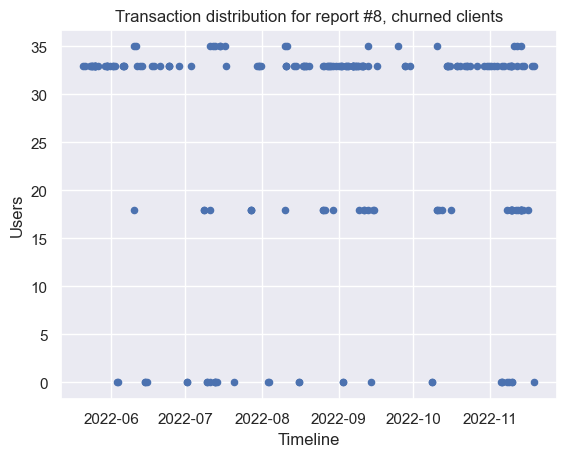

In [21]:
transactions_r8_u40[transactions_r8_u40['target'] == 1].plot.scatter(x='transaction_dttm', y='index')
plt.title('Transaction distribution for report #8, churned clients')
plt.xlabel('Timeline')
plt.ylabel('Users')

## Handling nulls

In [22]:
clients_df.isna().sum()

user_id                  0
report                   0
employee_count_nm    36466
bankemplstatus           0
customer_age             0
dtype: int64

In [23]:
clients_df['employee_count_nm'].value_counts(dropna=False)

employee_count_nm
NaN               36466
БОЛЕЕ 1001        17833
ОТ 101 ДО 500     14362
ОТ 51 ДО 100       7314
ОТ 501 ДО 1000     6481
ОТ 11 ДО 50        4413
ДО 10              3797
БОЛЕЕ 500          1996
ОТ 11 ДО 30        1871
ОТ 31 ДО 50        1467
Name: count, dtype: int64

In [24]:
clients_df['employee_count_nm'] = clients_df['employee_count_nm'].fillna('НЕТ')

In [25]:
src_train_df.isna().sum()

user_id    0
target     0
time       0
dtype: int64

In [26]:
report_dates_df.isna().sum()

report       0
report_dt    0
dtype: int64

In [27]:
transactions_df.isna().sum()

user_id             0
mcc_code            0
currency_rk         0
transaction_amt     0
transaction_dttm    0
dtype: int64

# Data preprocessing

Encode ***employee_count_nm*** in ascending order, since the nature of the feature implies a ranked representation

In [28]:
clients_df['employee_count_nm_code'] = clients_df['employee_count_nm'].replace({
    'НЕТ': 0,
    'ДО 10': 1, 
    'ОТ 11 ДО 30': 2,
    'ОТ 11 ДО 50': 3,
    'ОТ 31 ДО 50': 4,
    'ОТ 51 ДО 100': 5,
    'ОТ 101 ДО 500': 6, 
    'БОЛЕЕ 500': 7,
    'ОТ 501 ДО 1000': 8, 
    'БОЛЕЕ 1001': 9, 
}).fillna(0)

clients_df = clients_df.merge(report_dates_df, on='report', how='left')
clients_df['report_dt'] = pd.to_datetime(clients_df['report_dt'])
clients_df.shape

(96000, 7)

## Datetime processing


In [29]:
dates = pd.to_datetime(transactions_df['transaction_dttm'])

In [30]:
print(f'First transaction date: {min(dates)}')
print(f'Last transaction date: {max(dates)}')

First transaction date: 2021-10-20 09:00:00
Last transaction date: 2023-03-20 20:59:58


In [31]:
transactions_df['transaction_dttm'] = dates
# Forming features from date and time
transactions_df['date'] = dates.dt.date
transactions_df['weekday'] = dates.dt.weekday
transactions_df['year'] = dates.dt.year
transactions_df['month'] = dates.dt.month
transactions_df['hour'] = dates.dt.hour
# Weekends
transactions_df['is_weekend'] = np.where(transactions_df['weekday'].isin([5, 6]), 1, 0)
# Determine the period of the beginning or end of the year
transactions_df['begin_of_year'] = np.where(transactions_df['month'].isin([1,2]), 1, 0)
transactions_df['end_of_year'] = np.where(transactions_df['month'].isin([11,12]), 1, 0)
# Season
transactions_df['season_of_year'] = np.where(
    transactions_df['month'].isin([12, 1, 2]), 'winter', 
        np.where(transactions_df['month'].between(3,5), 'spring',
            np.where(transactions_df['month'].between(6,8), 'summer', 'fall')))
# Time of day
transactions_df['time_of_day'] = np.where(
    transactions_df['hour'].between(0, 4), 'night', 
        np.where(transactions_df['hour'].between(5, 9), 'morning',
            np.where(transactions_df['hour'].between(10,18), 'day', 'evening')))

transactions_df.shape

(13075023, 15)

In [32]:
transactions_df.dtypes

user_id                      int64
mcc_code                     int64
currency_rk                  int64
transaction_amt            float64
transaction_dttm    datetime64[ns]
date                        object
weekday                      int32
year                         int32
month                        int32
hour                         int32
is_weekend                   int32
begin_of_year                int32
end_of_year                  int32
season_of_year              object
time_of_day                 object
dtype: object

In [33]:
get_types(transactions_df.iloc[0])

[('user_id', numpy.int64),
 ('mcc_code', numpy.int64),
 ('currency_rk', numpy.int64),
 ('transaction_amt', numpy.float64),
 ('transaction_dttm', pandas._libs.tslibs.timestamps.Timestamp),
 ('date', datetime.date),
 ('weekday', numpy.int32),
 ('year', numpy.int32),
 ('month', numpy.int32),
 ('hour', numpy.int32),
 ('is_weekend', numpy.int32),
 ('begin_of_year', numpy.int32),
 ('end_of_year', numpy.int32),
 ('season_of_year', str),
 ('time_of_day', str)]

## Normalizing transaction amounts

Factoring in
- EUR (***currency_rk*** = 2) and USD (***currency_rk*** = 3) rates,
- CNY rate for any other currency (***currency_rk*** = 0)*,
- inflation.

\* Let's take the rate of Chinese Yuan (CYN) to represent 0, because: 
1. it is the 3rd most popular currency in Russia in 2022 - 2023 after the USD and the EUR [Forbes](https://www.forbes.ru/investicii/480428-spros-na-uan-v-rossijskih-bankah-vyros-v-razy-kto-i-kak-ego-pokupaet),
2. in February 2023 it became the most traded currency on Moscow Exchange (MOEX) [Rambler](https://finance.rambler.ru/markets/50434944-yuan-stal-samoy-torguemoy-valyutoy-v-rossii/).
3. the rate of the CYN is ~10 RUB and was consistent throughout the observed years (except for short period in spring 2022).

In [34]:
transactions_df['currency_rk'].value_counts(normalize=True)

currency_rk
1    0.971396
0    0.028333
3    0.000137
2    0.000134
Name: proportion, dtype: float64

Upload USD, EUR, CNY rates in period 01.10.2021 - 31.03.2023 with respect to RUB [CBR](https://www.cbr.ru/eng/currency_base/dynamics/?UniDbQuery.Posted=True&UniDbQuery.so=1&UniDbQuery.mode=1&UniDbQuery.date_req1=&UniDbQuery.date_req2=&UniDbQuery.VAL_NM_RQ=R01235&UniDbQuery.From=01.10.2021&UniDbQuery.To=31.03.2023).
Upload inflation in period 01.10.2021 - 31.03.2023 to factor it in later [ROSSTAT](https://rosstat.gov.ru/statistics/price) or [Tabular](https://xn----ctbjnaatncev9av3a8f8b.xn--p1ai/%D1%82%D0%B0%D0%B1%D0%BB%D0%B8%D1%86%D1%8B-%D0%B8%D0%BD%D1%84%D0%BB%D1%8F%D1%86%D0%B8%D0%B8).

For inflation, we are interested in monthly inflation since we need to calculate cumulative inflation since December 2021 - October will be taken as basis with no (0%) inflation (used xlsx spreadsheet was filled manually).

In [35]:
# Load currencies
USD_df = pd.read_excel(DATASETS_PATH / 'addons/USD_RC_F01_10_2021_T31_03_2023.xlsx')
EUR_df = pd.read_excel(DATASETS_PATH / 'addons/EUR_RC_F01_10_2021_T31_03_2023.xlsx')
CNY_df = pd.read_excel(DATASETS_PATH / 'addons/CNY_RC_F01_10_2021_T31_03_2023.xlsx')
# Load inflation
INFL_df = pd.read_excel(DATASETS_PATH / 'addons/Inflation.xlsx')

In [36]:
USD_dict = {d.strftime('%Y-%m-%d') : c/n for d, c, n in CNY_df[['data', 'curs', 'nominal']].to_dict('split')['data']}
EUR_dict = {d.strftime('%Y-%m-%d') : c/n for d, c, n in CNY_df[['data', 'curs', 'nominal']].to_dict('split')['data']}
CNY_dict = {d.strftime('%Y-%m-%d') : c/n for d, c, n in CNY_df[['data', 'curs', 'nominal']].to_dict('split')['data']}

INFL_dict = {}
for y, m, c in INFL_df[['year', 'month', 'cumulative_inflation']].to_dict('split')['data']:
    if y not in INFL_dict:
        INFL_dict[y] = {}
    INFL_dict[y][m] = c

In [37]:
USD_df['year'] = USD_df['data'].dt.year
USD_df['month'] = USD_df['data'].dt.month

EUR_df['year'] = EUR_df['data'].dt.year
EUR_df['month'] = EUR_df['data'].dt.month

CNY_df['year'] = CNY_df['data'].dt.year
CNY_df['month'] = CNY_df['data'].dt.month

USD_dict = create_money_dict(USD_df.groupby(by=['year', 'month'])['curs'].mean())
EUR_dict = create_money_dict(EUR_df.groupby(by=['year', 'month'])['curs'].mean())
CNY_dict = create_money_dict(CNY_df.groupby(by=['year', 'month'])['curs'].mean())
INFL_dict = create_money_dict(INFL_df[['year', 'month', 'cumulative_inflation']].rename(columns={'cumulative_inflation': 'curs'}))

In [38]:
transactions_df['normal_transaction_amt'] = transactions_df.progress_apply(lambda x: amt_normalize(x), axis=1)

100%|██████████| 13075023/13075023 [03:32<00:00, 61485.60it/s]


## Handle transactions as two entities:
1. Plus ~ Deposit of funds.
2. Minus ~ Expenses (payments for services and goods).

In [39]:
transactions_df['plus_normal_transaction_amt'] = np.where(transactions_df['normal_transaction_amt'] > 0, transactions_df['normal_transaction_amt'], 0) 
transactions_df['minus_normal_transaction_amt'] = np.where(transactions_df['normal_transaction_amt'] < 0, transactions_df['normal_transaction_amt'], 0) 

In [40]:
get_types(transactions_df[['normal_transaction_amt']].iloc[0])

[('normal_transaction_amt', float)]

# Features
## User related features

In [41]:
agg__mcc_group_transactions_df = transactions_df.copy()
agg__mcc_group_transactions_df = agg__mcc_group_transactions_df.merge(clients_df, on='user_id')
agg__mcc_group_transactions_df.shape

(13075023, 24)

In [42]:
%%time
# mad is deprecated since pandas version 1.5.0
tmp_df = agg__mcc_group_transactions_df.groupby(by=['user_id']).agg(
    
    amt_count = ('transaction_amt', len),
    amt_sum = ('transaction_amt', 'sum'),
    amt_std = ('transaction_amt', 'std'),
    amt_median = ('transaction_amt', 'median'),
    amt_min = ('transaction_amt', 'min'),
    amt_max = ('transaction_amt', 'max'),

    amt_var = ('transaction_amt', 'var'),
    # amt_mad = ('transaction_amt', 'mad'),
    amt_skew = ('transaction_amt', skew),

    amt_normal_count = ('normal_transaction_amt', len),
    amt_normal_sum = ('normal_transaction_amt', 'sum'),
    amt_normal_std = ('normal_transaction_amt', 'std'),
    amt_normal_median = ('normal_transaction_amt', 'median'),
    amt_normal_min = ('normal_transaction_amt', 'min'),
    amt_normal_max = ('normal_transaction_amt', 'max'),
    amt_normal_var = ('normal_transaction_amt', 'var'),
    # amt_normal_mad = ('normal_transaction_amt', 'mad'),
    amt_normal_skew = ('normal_transaction_amt', skew),            

    # Deposits
    plus_amt_normal_count = ('plus_normal_transaction_amt', len),
    plus_amt_normal_sum = ('plus_normal_transaction_amt', 'sum'),
    plus_amt_normal_std = ('plus_normal_transaction_amt', 'std'),
    plus_amt_normal_median = ('plus_normal_transaction_amt', 'median'),
    plus_amt_normal_min = ('plus_normal_transaction_amt', 'min'),
    plus_amt_normal_max = ('plus_normal_transaction_amt', 'max'),
    plus_amt_normal_var = ('plus_normal_transaction_amt', 'var'),
    # plus_amt_normal_mad = ('plus_normal_transaction_amt', 'mad'),
    plus_amt_normal_skew = ('plus_normal_transaction_amt', skew),            

    # Expenses
    minus_amt_normal_count = ('minus_normal_transaction_amt', len),
    minus_amt_normal_sum = ('minus_normal_transaction_amt', 'sum'),
    minus_amt_normal_std = ('minus_normal_transaction_amt', 'std'),
    minus_amt_normal_median = ('minus_normal_transaction_amt', 'median'),
    minus_amt_normal_min = ('minus_normal_transaction_amt', 'min'),
    minus_amt_normal_max = ('minus_normal_transaction_amt', 'max'),
    minus_amt_normal_var = ('minus_normal_transaction_amt', 'var'),
    # minus_amt_normal_mad = ('minus_normal_transaction_amt', 'mad'),
    minus_amt_normal_skew = ('minus_normal_transaction_amt', skew),

    uniq_mcc = ('mcc_code', pd.Series.nunique),
    uniq_currency = ('currency_rk', pd.Series.nunique),
    
    min_date = ('date', 'min'),
    max_date = ('date', 'max'),

    # Number of unique days of the week when the client made transactions.
    # If 7 then the client made transactions every day, if 1 then only on a single day.
    count_weekday = ('weekday', pd.Series.nunique),
    # Weekday mode
    mode_weekday = ('weekday', mode),
    skew_weekday = ('weekday', skew),
    
    mean_is_weekend = ('is_weekend', 'mean'),
    mean_begin_of_year = ('begin_of_year', 'mean'),
    mean_end_of_year = ('end_of_year', 'mean'),
    mean_hour = ('hour', 'mean'),
    
    # Other modes
    mode_month = ('month', mode),
    mode_season_of_year = ('season_of_year', mode), 
    mode_time_of_day = ('time_of_day', mode),
    mode_mcc_code = ('mcc_code', mode),

).add_suffix('__agg_user')  

CPU times: total: 1min 20s
Wall time: 3min 1s


In [43]:
tmp_df['count_most_weekday__agg_user'] = tmp_df['mode_weekday__agg_user'].apply(lambda x: x[1])
tmp_df['most_weekday__agg_user'] = tmp_df['mode_weekday__agg_user'].apply(lambda x: x[0])

tmp_df['count_most_month__agg_user'] = tmp_df['mode_month__agg_user'].apply(lambda x: x[1])
tmp_df['most_month__agg_user'] = tmp_df['mode_month__agg_user'].apply(lambda x: x[0])

tmp_df['count_most_season_of_year__agg_user'] = tmp_df['mode_season_of_year__agg_user'].apply(lambda x: x[1])
tmp_df['most_season_of_year__agg_user'] = tmp_df['mode_season_of_year__agg_user'].apply(lambda x: x[0])

tmp_df['count_most_time_of_day__agg_user'] = tmp_df['mode_time_of_day__agg_user'].apply(lambda x: x[1])
tmp_df['most_time_of_day__agg_user'] = tmp_df['mode_time_of_day__agg_user'].apply(lambda x: x[0])

tmp_df.shape

(96000, 55)

In [44]:
get_types(tmp_df.iloc[0])

[('amt_count__agg_user', numpy.int64),
 ('amt_sum__agg_user', numpy.float64),
 ('amt_std__agg_user', numpy.float64),
 ('amt_median__agg_user', numpy.float64),
 ('amt_min__agg_user', numpy.float64),
 ('amt_max__agg_user', numpy.float64),
 ('amt_var__agg_user', numpy.float64),
 ('amt_skew__agg_user', numpy.float64),
 ('amt_normal_count__agg_user', numpy.int64),
 ('amt_normal_sum__agg_user', numpy.float64),
 ('amt_normal_std__agg_user', numpy.float64),
 ('amt_normal_median__agg_user', numpy.float64),
 ('amt_normal_min__agg_user', numpy.float64),
 ('amt_normal_max__agg_user', numpy.float64),
 ('amt_normal_var__agg_user', numpy.float64),
 ('amt_normal_skew__agg_user', numpy.float64),
 ('plus_amt_normal_count__agg_user', numpy.int64),
 ('plus_amt_normal_sum__agg_user', numpy.float64),
 ('plus_amt_normal_std__agg_user', numpy.float64),
 ('plus_amt_normal_median__agg_user', numpy.float64),
 ('plus_amt_normal_min__agg_user', numpy.float64),
 ('plus_amt_normal_max__agg_user', numpy.float64),
 ('

## User-specific features relative to popular mcc codes

### Top 50 MCC grouping

In [45]:
# Get most popular MCC codes with more than 20000 transactions (top 51)
# They will be used as separate features for grouping
pop_mcc = agg__mcc_group_transactions_df.mcc_code.value_counts()
pop_mcc = pop_mcc[pop_mcc >= 20000]
pop_mcc_columns = [f'mcc_code___{c}' for c in pop_mcc.index]
pop_mcc

mcc_code
1      4152654
2      1065363
4       947720
3       719400
0       582177
11      520796
6       440264
8       418128
7       381862
9       212977
17      207845
10      197535
14      196364
13      195273
155     181282
15      153964
12      149701
26      142919
32       94779
28       85048
33       83091
18       75076
22       74746
23       74116
21       74015
25       72697
20       69785
27       62718
16       53029
52       52127
24       49453
30       45247
31       42086
44       40850
34       38541
47       36680
61       30080
37       29705
43       27299
50       25616
66       24625
72       24529
45       24523
42       24466
36       23501
39       23360
49       22338
108      22097
51       21490
99       20607
57       20355
Name: count, dtype: int64

In [46]:
mcc_transactions_df = pd.get_dummies(agg__mcc_group_transactions_df['mcc_code'], prefix='mcc_code__')
mcc_transactions_df.shape

(13075023, 332)

In [47]:
# Delete if accidentally added already
agg__mcc_group_transactions_df = agg__mcc_group_transactions_df.drop(columns=[f'{i}_x' for i in pop_mcc_columns], errors='ignore')
agg__mcc_group_transactions_df = agg__mcc_group_transactions_df.drop(columns=[f'{i}_y' for i in pop_mcc_columns], errors='ignore')
agg__mcc_group_transactions_df = agg__mcc_group_transactions_df.drop(columns=[i for i in pop_mcc_columns], errors='ignore')

agg__mcc_group_transactions_df = agg__mcc_group_transactions_df.merge(mcc_transactions_df[pop_mcc_columns], left_index=True, right_index=True)
agg__mcc_group_transactions_df.shape

(13075023, 75)

In [48]:
# Split mcc_code into 10 groups
cat_mcc_code = pd.qcut(agg__mcc_group_transactions_df['mcc_code'], 10, duplicates='drop')
agg__mcc_group_transactions_df['cat_mcc_code'] = cat_mcc_code
agg__mcc_group_transactions_df['cat_mcc_code'] = agg__mcc_group_transactions_df['cat_mcc_code'].cat.rename_categories([f'cat_mcc_code_{i}' for i in range(len(agg__mcc_group_transactions_df['cat_mcc_code'].unique())) ])

In [49]:
# Only 8 unique groups were obtained
cat_mcc_code.unique()

[(2.0, 4.0], (11.0, 17.0], (37.0, 449.0], (-0.001, 1.0], (17.0, 37.0], (1.0, 2.0], (6.0, 11.0], (4.0, 6.0]]
Categories (8, interval[float64, right]): [(-0.001, 1.0] < (1.0, 2.0] < (2.0, 4.0] < (4.0, 6.0] < (6.0, 11.0] < (11.0, 17.0] < (17.0, 37.0] < (37.0, 449.0]]

In [50]:
user_amt_by_mcc_aggregate_df = agg__mcc_group_transactions_df.pivot_table(
    index='user_id',
    values=['normal_transaction_amt', 'plus_normal_transaction_amt', 'minus_normal_transaction_amt'],
    columns=['cat_mcc_code'],
    aggfunc=['count', 'median', 'sum'],
    observed=False
)
user_amt_by_mcc_aggregate_df.columns = ['___'.join(col).strip() for col in user_amt_by_mcc_aggregate_df.columns.values]
user_amt_by_mcc_aggregate_df.shape

(96000, 72)

In [51]:
get_types(user_amt_by_mcc_aggregate_df.iloc[0])

[('count___minus_normal_transaction_amt___cat_mcc_code_0', float),
 ('count___minus_normal_transaction_amt___cat_mcc_code_1', float),
 ('count___minus_normal_transaction_amt___cat_mcc_code_2', float),
 ('count___minus_normal_transaction_amt___cat_mcc_code_3', float),
 ('count___minus_normal_transaction_amt___cat_mcc_code_4', float),
 ('count___minus_normal_transaction_amt___cat_mcc_code_5', float),
 ('count___minus_normal_transaction_amt___cat_mcc_code_6', float),
 ('count___minus_normal_transaction_amt___cat_mcc_code_7', float),
 ('count___normal_transaction_amt___cat_mcc_code_0', float),
 ('count___normal_transaction_amt___cat_mcc_code_1', float),
 ('count___normal_transaction_amt___cat_mcc_code_2', float),
 ('count___normal_transaction_amt___cat_mcc_code_3', float),
 ('count___normal_transaction_amt___cat_mcc_code_4', float),
 ('count___normal_transaction_amt___cat_mcc_code_5', float),
 ('count___normal_transaction_amt___cat_mcc_code_6', float),
 ('count___normal_transaction_amt___c

In [52]:
agg_df = tmp_df.merge(user_amt_by_mcc_aggregate_df, left_index=True, right_index=True)
agg_df.shape

(96000, 127)

In [53]:
agg_df = agg_df.merge(clients_df, on='user_id')
agg_df['max_date__agg_user'] = pd.to_datetime(agg_df['max_date__agg_user'])
agg_df['min_date__agg_user'] = pd.to_datetime(agg_df['min_date__agg_user'])
agg_df['delta_report_last_date'] = (agg_df['report_dt'] - agg_df['max_date__agg_user']).dt.days
agg_df['delta_report_first_date'] = (agg_df['report_dt'] - agg_df['min_date__agg_user']).dt.days
agg_df['delta_first_last_date'] = (agg_df['max_date__agg_user'] - agg_df['min_date__agg_user']).dt.days
# Datetime delta from '2010-01-01'
agg_df['days_report_dt'] = (agg_df['report_dt'] - pd.to_datetime('2010-01-01')).dt.days
agg_df['days_min_date'] = (agg_df['min_date__agg_user'] - pd.to_datetime('2010-01-01')).dt.days
agg_df['days_max_date'] = (agg_df['max_date__agg_user'] - pd.to_datetime('2010-01-01')).dt.days
agg_df = agg_df.drop(columns=['amt_prod__agg_user'], errors='ignore')
agg_df.shape

(96000, 140)

In [54]:
# Дополнительные признаки
agg_df[f'amt_normal_sum__agg_user__**2'] = agg_df[f'amt_normal_sum__agg_user'] * agg_df[f'amt_normal_sum__agg_user']
agg_df[f'amt_normal_median__agg_user__**2'] = agg_df[f'amt_normal_median__agg_user'] * agg_df[f'amt_normal_median__agg_user']
agg_df[f'amt_normal_max__agg_user__**2'] = agg_df[f'amt_normal_max__agg_user'] * agg_df[f'amt_normal_max__agg_user']
agg_df[f'minus_amt_normal_skew__agg_user__**2'] = agg_df[f'minus_amt_normal_skew__agg_user'] * agg_df[f'minus_amt_normal_skew__agg_user']
agg_df[f'amt_normal_median__agg_user___uniq_mcc__agg_user'] = agg_df[f'amt_normal_median__agg_user'] * agg_df[f'uniq_mcc__agg_user']
agg_df.shape

(96000, 145)

## Active/non-active periods (transaction flow statistics)

In [55]:
non_active_period_df = transactions_df.groupby(by='user_id').progress_apply(lambda x: pd.Series(non_active_period(x)))
non_active_period_df.columns = [
    'last_account_hit', 'last_account_charge', 'first_account_hit', 
    'first_account_charge', 'active_period', 'unique_active_days', 
    'all_period', 'median_non_active_period', 'max_non_active_period', 
    'prc_non_active_period', 'prc_non_active_period_by_days', 
    'freq_active_transact_count', 'freq_active_day',
    'count_account_hit', 'count_account_charge'
]
non_active_period_df.shape

100%|██████████| 96000/96000 [05:07<00:00, 312.68it/s]


(96000, 15)

In [56]:
non_active_period_df['first_account_hit'] = pd.to_datetime(non_active_period_df['first_account_hit'])
non_active_period_df['last_account_hit'] = pd.to_datetime(non_active_period_df['last_account_hit'])
non_active_period_df['first_account_charge'] = pd.to_datetime(non_active_period_df['first_account_charge'])
non_active_period_df['last_account_charge'] = pd.to_datetime(non_active_period_df['last_account_charge'])

non_active_period_df['first_account_hit'] = non_active_period_df['first_account_hit'].fillna(non_active_period_df['first_account_charge'] - timedelta(days=200))
non_active_period_df['last_account_hit'] = non_active_period_df['last_account_hit'].fillna(non_active_period_df['first_account_hit'])
non_active_period_df['first_account_charge'] = non_active_period_df['first_account_charge'].fillna(non_active_period_df['first_account_hit'])
non_active_period_df['last_account_charge'] = non_active_period_df['last_account_charge'].fillna(non_active_period_df['first_account_charge'])

non_active_period_df.shape

(96000, 15)

In [57]:
agg_df1 = agg_df.merge(non_active_period_df.reset_index(), on='user_id')
agg_df1.shape

(96000, 160)

In [58]:
speed_charge_df = transactions_df.groupby(by='user_id').progress_apply(lambda x: pd.Series(speed_charge(x)))
speed_charge_df.columns = [
'cur_period_sum_plus', 'pre_period_sum_plus', 'pre_pre_period_sum_plus',
'cur_period_sum_minus', 'pre_period_sum_minus', 'pre_pre_period_sum_minus',
'plus_speed_cur', 'plus_speed_pre', 'plus_speed_cur_prepre',
'minus_speed_cur', 'minus_speed_pre', 'minus_speed_cur_prepre',
]
speed_charge_df.shape

100%|██████████| 96000/96000 [04:55<00:00, 324.96it/s]


(96000, 12)

In [59]:
agg_df2 = agg_df1.merge(speed_charge_df.reset_index(), on='user_id')
agg_df2.shape

(96000, 172)

In [60]:
agg_df2.to_csv(INTERNAL_PATH / 'agg_df2.csv', index=False)

## Add additional features to transactions (will be used to filter train dataset!) 

In [61]:
transactions_df = transactions_df.merge(clients_df, on='user_id')
transactions_df['sign'] = transactions_df['transaction_amt'].apply(lambda x: 'positive' if x >= 0 else 'negative')
transactions_df[['currency_rk']] = transactions_df[['currency_rk']].map(lambda x: 0 if x != 1 else 1)
transactions_df['day'] = transactions_df['transaction_dttm'].dt.day_of_year.astype(int)
transactions_df['report_dt'] = transactions_df['report_dt'].dt.date
transactions_df['delta_date'] = transactions_df['report_dt'] - transactions_df['date']
transactions_df['delta_date'] = transactions_df['delta_date'].map(lambda x: x.days)
transactions_df['employee_count_nm'] = transactions_df['employee_count_nm'].fillna('НЕИЗВЕСТНО')
transactions_df.shape

(13075023, 27)

In [ ]:
# transactions_df.to_csv(INTERNAL_PATH / 'new_transactions.csv', index=False)

## Forming a training sample

In [ ]:
# agg_df2 = pd.read_csv(INTERNAL_PATH / 'agg_df2.csv')

In [65]:
train_df = agg_df2[agg_df2['user_id'].isin(src_train_df['user_id'])]
submit_df = agg_df2[~agg_df2['user_id'].isin(src_train_df['user_id'])]
train_df = train_df.merge(src_train_df, on='user_id')
train_df.shape, submit_df.shape

((64000, 174), (32000, 172))

In [67]:
feature_columns, target_column, num_features, cat_features, ignored_features = get_column_names(train_df, full=True)
len(feature_columns) - 1 # 'user_id' can cause leaking

159

# Regression model with cross-validation for predicting last transaction time and its quantiles

In [68]:
cv_target_column = 'time'
bin_target_column = 'target'

cv_X_train = train_df[feature_columns]
cv_y_train = train_df[cv_target_column]
X_submit = submit_df[feature_columns]

cv_X_train.shape, cv_y_train.shape, X_submit.shape

((64000, 160), (64000,), (32000, 160))

In [69]:
%%time
seed_everything(seed)

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error


train_df['predict_time'] = np.nan
qnt_columns = ['time_pred_001', 'time_pred_005', 'time_pred_01', 'time_pred_03', 'time_pred_05', 'time_pred_07']
train_df[qnt_columns] = np.nan

kf = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True)

for i, (train_index, test_index) in enumerate(kf.split(cv_X_train, train_df[bin_target_column])):
    print(f'fold: {i+1}')
    print(f'train_index: {len(train_index)}, test_index: {len(test_index)}')
    fold_X_train = cv_X_train.iloc[train_index]
    fold_y_train = cv_y_train.iloc[train_index]
    fold_X_train, fold_X_val, fold_y_train, fold_y_val = train_test_split(
        fold_X_train, fold_y_train, test_size=0.05, random_state=seed)
    
    fold_X_test = cv_X_train.iloc[test_index]
    fold_y_test = cv_y_train.iloc[test_index]
    
    # fold_model_reg = CatBoostRegressor(eval_metric="RMSE", early_stopping_rounds=20, iterations=2000, random_state=seed, cat_features=cat_features)
    fold_model_reg = CatBoostRegressor(
        eval_metric="MAE", early_stopping_rounds=200, iterations=2000,
        random_state=seed, cat_features=cat_features, ignored_features=['user_id'])
    
    fold_model_reg.fit(fold_X_train, fold_y_train,
                       eval_set=(fold_X_val, fold_y_val),
                       plot=True, verbose=False)

    qnt_fold_model_reg = CatBoostRegressor(
        loss_function='MultiQuantile:alpha=0.01, 0.05, 0.1, 0.3, 0.5, 0.7',
        early_stopping_rounds=200, iterations=2000, random_state=seed,
        cat_features=cat_features, ignored_features=['user_id'])
    
    qnt_fold_model_reg.fit(fold_X_train, fold_y_train,
                           eval_set=(fold_X_val, fold_y_val), plot=True, verbose=False)
    # train_df[qnt_columns].iloc[test_index] = qnt_fold_model_reg.predict(fold_X_test)
    train_df.loc[test_index, qnt_columns] = qnt_fold_model_reg.predict(fold_X_test)
    
    predict_time = fold_model_reg.predict(fold_X_test)
    train_df['predict_time'].iloc[test_index] = predict_time
    fold_mae = mean_absolute_error(y_true=fold_y_test, y_pred=predict_time)
    print(f'MAE fold #{i}: {fold_mae}')

train_df[qnt_columns] = np.sort(train_df[qnt_columns].values)
train_df.shape

fold: 1
train_index: 51200, test_index: 12800


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MAE fold #0: 11.182748150413822
fold: 2
train_index: 51200, test_index: 12800


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MAE fold #1: 11.230328701191192
fold: 3
train_index: 51200, test_index: 12800


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MAE fold #2: 10.896658052884877
fold: 4
train_index: 51200, test_index: 12800


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MAE fold #3: 11.096877524521055
fold: 5
train_index: 51200, test_index: 12800


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MAE fold #4: 11.115469792475473
CPU times: total: 32min 3s
Wall time: 11min 52s


(64000, 181)

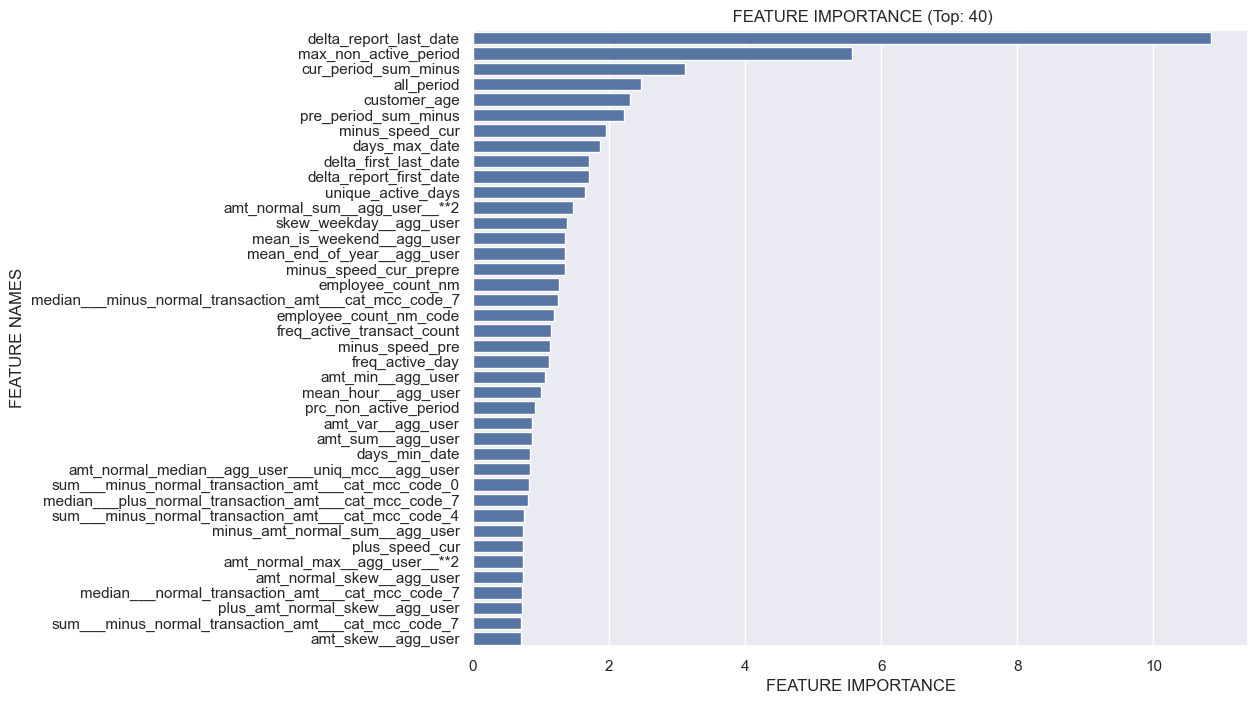

In [70]:
fi_df = plot_feature_importance(fold_model_reg.get_feature_importance(),
                                fold_X_train.columns,
                                model_name='', top_n=40)

#### Fill ***time_predict*** 

In [71]:
%%time
model_reg = CatBoostRegressor(eval_metric="RMSE", early_stopping_rounds=100, iterations=800, random_state=seed, cat_features=cat_features, ignored_features=['user_id'])
model_reg.fit(cv_X_train, cv_y_train, plot=False, verbose=False)

CPU times: total: 30.2 s
Wall time: 52.4 s


In [72]:
X_submit['predict_time'] = model_reg.predict(X_submit[feature_columns])

In [73]:
%%time
qnt_model_reg = CatBoostRegressor(
    loss_function='MultiQuantile:alpha=0.01, 0.05, 0.1, 0.3, 0.5, 0.7',
    early_stopping_rounds=100, iterations=700, random_state=seed,
    cat_features=cat_features, ignored_features=['user_id'])
qnt_model_reg.fit(cv_X_train, cv_y_train, plot=False, verbose=False)

CPU times: total: 5min 17s
Wall time: 1min 32s


In [74]:
X_submit[qnt_columns] = qnt_model_reg.predict(X_submit[feature_columns])
X_submit[qnt_columns] = np.sort(X_submit[qnt_columns].values)
X_submit.shape

(32000, 167)

In [75]:
clf_feature_columns = list(set(feature_columns + ['predict_time'] + qnt_columns))
len(clf_feature_columns)

167

### Handling outliers

In [76]:
t_d1 = transactions_df.groupby(['user_id', 'day'])['day'].count()
t1 = t_d1[t_d1 > 20].unstack()
print(np.setdiff1d(src_train_df[['user_id']], t1.index).shape)

t_d2 = transactions_df.groupby(['user_id','day'])['mcc_code'].nunique()
t2 = t_d2[t_d2 > 11].unstack()
print(np.setdiff1d(src_train_df[['user_id']], t2.index).shape)

no_outliers = np.setdiff1d(np.setdiff1d(src_train_df[['user_id']], t1.index), t2.index)
print(no_outliers.shape)

(63704,)
(63907,)
(63636,)


0 - not an outlier
1 - more than 20 transactions in at least one day
2 - more than 11 MCC codes in at least one day

In [77]:
train_df['outlier'] = train_df['user_id'].isin(t1.index).astype(int) + train_df['user_id'].isin(t2.index).astype(int) * 2

In [78]:
train_df_ = train_df[clf_feature_columns + [target_column, 'outlier']]
train_df_.to_csv(INTERNAL_PATH / 'train.csv', index=False)

X_submit_ = X_submit[clf_feature_columns]
X_submit_.to_csv(INTERNAL_PATH / 'submit_time.csv', index=False)

train_df_.shape, X_submit_.shape

((64000, 169), (32000, 167))